## Add path to source files

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.path.abspath('..'), 'src'))

## If not already created, create folder for saving figures

In [2]:
save_folder = r'example-configuration-flow-test-thin-domain'
if not os.path.isdir(save_folder):
    os.makedirs(save_folder)

## Import necessary packages, make plots big

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import FiniteDifference as fd
import LiquidCrystalHelper as lch
import biharm as bh

import time
from importlib import reload

In [4]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Video
from IPython.display import Image

In [5]:
reload(lch)

<module 'LiquidCrystalHelper' from 'C:\\Users\\lucas\\Documents\\Grad Work\\Summer Research 2020\\LiquidCrystalHydrodynamics\\src\\LiquidCrystalHelper.py'>

In [6]:
%matplotlib inline
dpi = 700
mpl.rcParams['figure.dpi'] = dpi

## Set up domain

In [28]:
l = 70
n = 257

x = np.linspace(0, 2*l, num=n)
y = np.linspace(0, 2*l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

dx = x[1] - x[0]
dy = y[1] - y[0]

## Set up example configuration:
$S = \text{const.}, \hat{n} = \left( \epsilon \cos x, 0, 1 \right)$

In [29]:
epsilon = 0.1
S = 0.5
n_hat = np.zeros((3,) + np.shape(X))

k_x = 10*np.pi/(2*l)

n_hat[0] = epsilon*np.cos(k_x*X)
n_hat[1] = 1

Q = np.zeros((3, 3) + np.shape(X))
I = np.eye(n, n)

for i in range(3):
    for j in range(3):
        Q[i, j] = (S/2)*(3*n_hat[i]*n_hat[j] - I[i, j])

## Calculate auxiliary variables

In [30]:
eta, mu, nu = lch.auxVars(Q)

## Plot the configuration

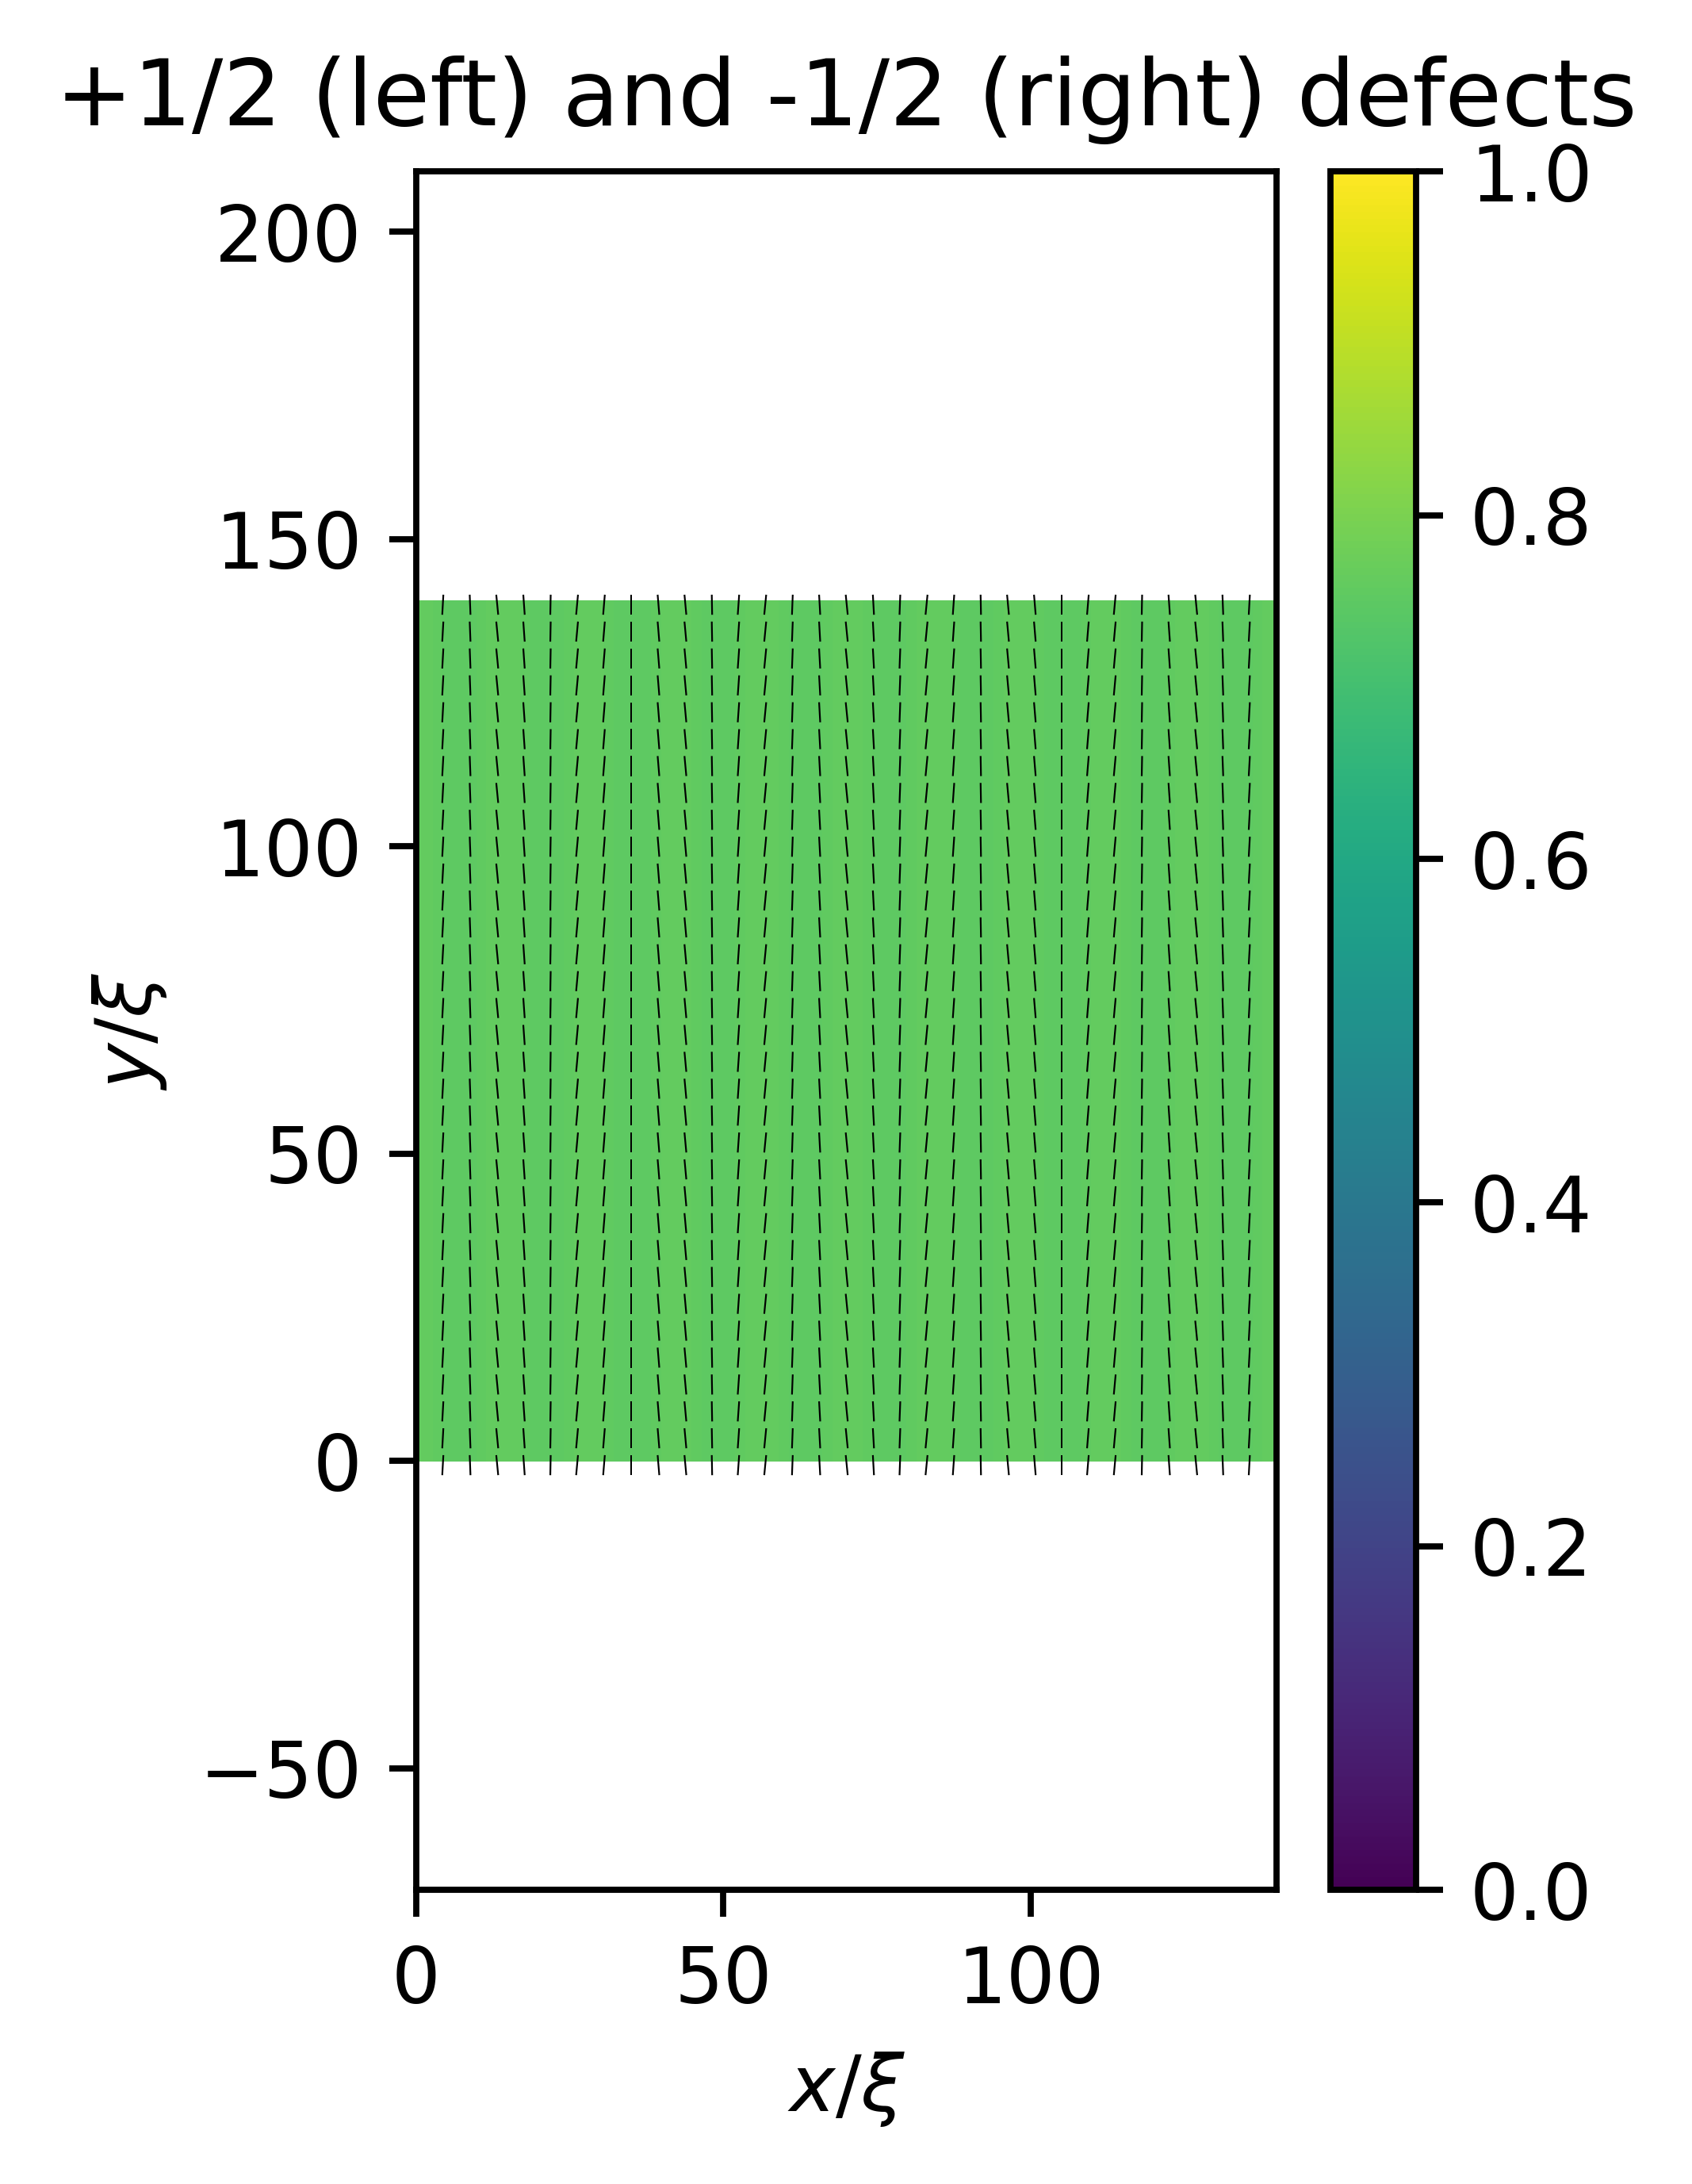

In [31]:
sparse_shape = (30, 30)
S_sparse_shape = (257, 257)
S_cutoff = 0.3

lambda_max = lch.calcQEigenvals(eta, mu, nu)
U, V = lch.calcQEigenvecs(eta, mu, nu, lambda_max, S_cutoff)

sparse_idx = lch.sparseIdx(Q[0, 0].shape, sparse_shape)
S_sparse_idx = lch.sparseIdx(Q[0, 0].shape, S_sparse_shape)

fig, ax = plt.subplots(figsize=(2.5, 4.1))
c = ax.pcolor(X[S_sparse_idx], Y[S_sparse_idx],  (3/2)*lambda_max[S_sparse_idx], vmin=0, vmax=1)
q = ax.quiver(X[sparse_idx], Y[sparse_idx], U[sparse_idx], V[sparse_idx],
              headwidth=0, pivot='middle', headaxislength=5, scale=30, width=0.002)

ax.axis('equal')
fig.colorbar(c, ax=ax)
ax.set_title("+1/2 (left) and -1/2 (right) defects")
ax.set_xlabel(r"$x/\xi$")
ax.set_ylabel(r"$y/\xi$")

filename_nematic = os.path.join(save_folder, r'nematic-configuration.png')
fig.savefig(filename_nematic)

## Set up biharmonic solver

In [32]:
L = [l, 2*l]
shape = [n - 1, n - 1]
alpha = 0
maxiter = 500

bh_solver = bh.Biharm(L, shape, alpha, cg_maxiter=maxiter)

## Actually solve the biharmonic equation

In [33]:
psi = np.zeros(eta.shape)
source_term = (1 / (lch.b - (1/4)*lch.a**2)) * ( 2*lch.f1(eta, mu, nu, dx, dy) + (1/2)*lch.a*lch.f2(eta, mu, nu, dx, dy) )
psi[1:-1, 1:-1], info, calls = bh_solver.solve(source_term[1:-1, 1:-1])

In [ ]:
vx1, vy1 = fd.curl(psi, dx, dy)
v = np.sqrt(vx1**2 + vy1**2)

mask = np.where(v != 0)
vx_norm = np.zeros(vx1.shape)
vy_norm = np.zeros(vy1.shape)
vx_norm[mask] = vx1[mask]/v[mask]
vy_norm[mask] = vy1[mask]/v[mask]

sparse_idx = lch.sparseIdx(vx1.shape, (30, 30))

fig, ax = plt.subplots(figsize=(2.5, 4.1))
c = ax.pcolor(X, Y, v)
fig.colorbar(c, ax=ax)
q = ax.quiver(X[sparse_idx], Y[sparse_idx],
              vx_norm[sparse_idx], vy_norm[sparse_idx], pivot='tail', color='w')
ax.set_title('Flow fields from numerical solver')
ax.set_xlabel(r'$x/\xi$')
ax.set_ylabel(r'$y/\xi$')
ax.axis('equal')

filename_stress_tensor = os.path.join(save_folder, r'flow-field-numerical-10-periods.png')
fig.savefig(filename_stress_tensor)

In [ ]:
plt.plot(X[:, 5], vy[:, 5])

In [31]:
alpha = 1/(lch.b - (1/4)*lch.a**2)
def analyticVelocity(x):
    return -3*alpha*lch.a*S/(4*k_x) * (lch.A + S*lch.B + 3*S**2/2 * lch.C + k_x**2) * epsilon * np.sin(k_x*x)

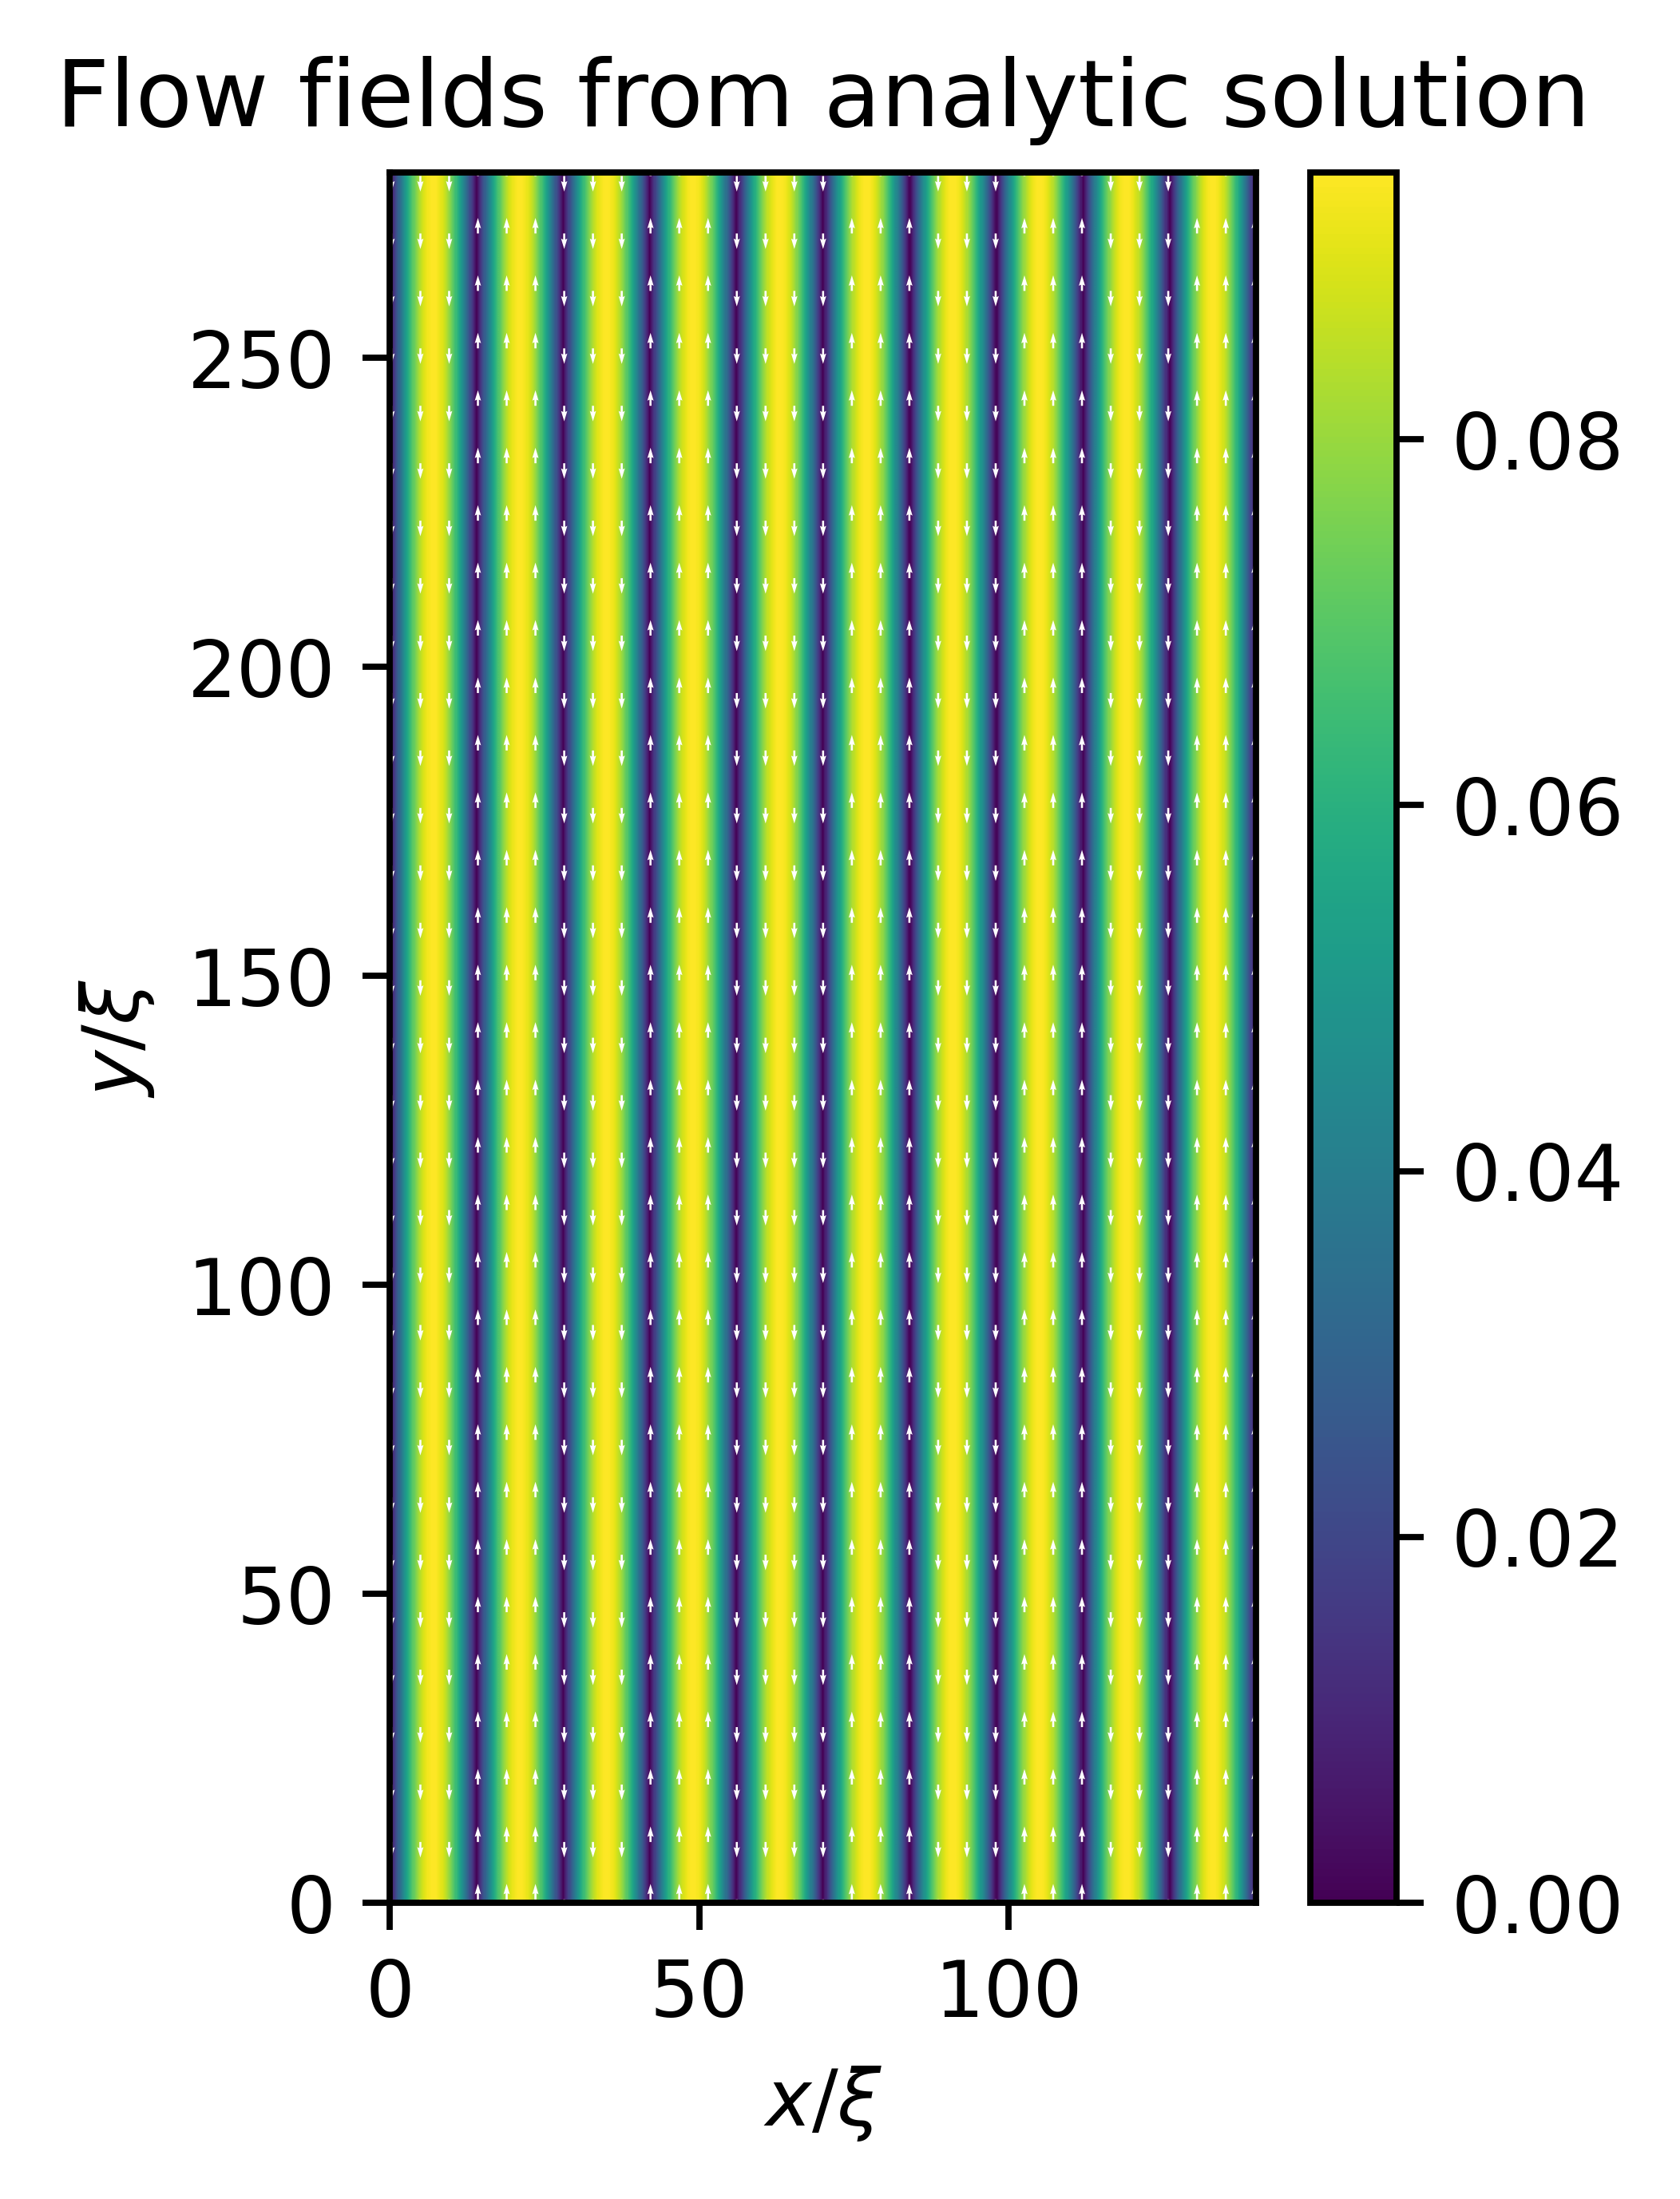

In [32]:
vx = 0*X
vy = analyticVelocity(X)
v = np.sqrt(vx**2 + vy**2)

mask = np.where(v != 0)
vx_norm = np.zeros(vx.shape)
vy_norm = np.zeros(vy.shape)
vx_norm[mask] = vx[mask]/v[mask]
vy_norm[mask] = vy[mask]/v[mask]

sparse_idx = lch.sparseIdx(vx.shape, (30, 30))

fig, ax = plt.subplots(figsize=(2.5, 4.1))
c = ax.pcolor(X, Y, v)
fig.colorbar(c, ax=ax)
q = ax.quiver(X[sparse_idx], Y[sparse_idx],
              vx_norm[sparse_idx], vy_norm[sparse_idx], pivot='tail', color='w')
ax.set_title('Flow fields from analytic solution')
ax.set_xlabel(r'$x/\xi$')
ax.set_ylabel(r'$y/\xi$')
ax.axis('equal')

filename_stress_tensor = os.path.join(save_folder, r'flow-field-analytic-10-periods.png')
fig.savefig(filename_stress_tensor)

# Now for 6 periods

In [51]:
epsilon = 0.1
S = 0.5
n_hat = np.zeros((3,) + np.shape(X))

k_x = 6*np.pi/l

n_hat[0] = epsilon*np.cos(k_x*X)
n_hat[1] = 1

Q = np.zeros((3, 3) + np.shape(X))
I = np.eye(n, n)

for i in range(3):
    for j in range(3):
        Q[i, j] = (S/2)*(3*n_hat[i]*n_hat[j] - I[i, j])

In [52]:
eta, mu, nu = lch.auxVars(Q)

In [53]:
psi = np.zeros(eta.shape)
source_term = (1 / (lch.b - (1/4)*lch.a**2)) * ( 2*lch.f1(eta, mu, nu, dx, dy) + (1/2)*lch.a*lch.f2(eta, mu, nu, dx, dy) )
psi[1:-1, 1:-1], info, calls = bh_solver.solve(source_term[1:-1, 1:-1])

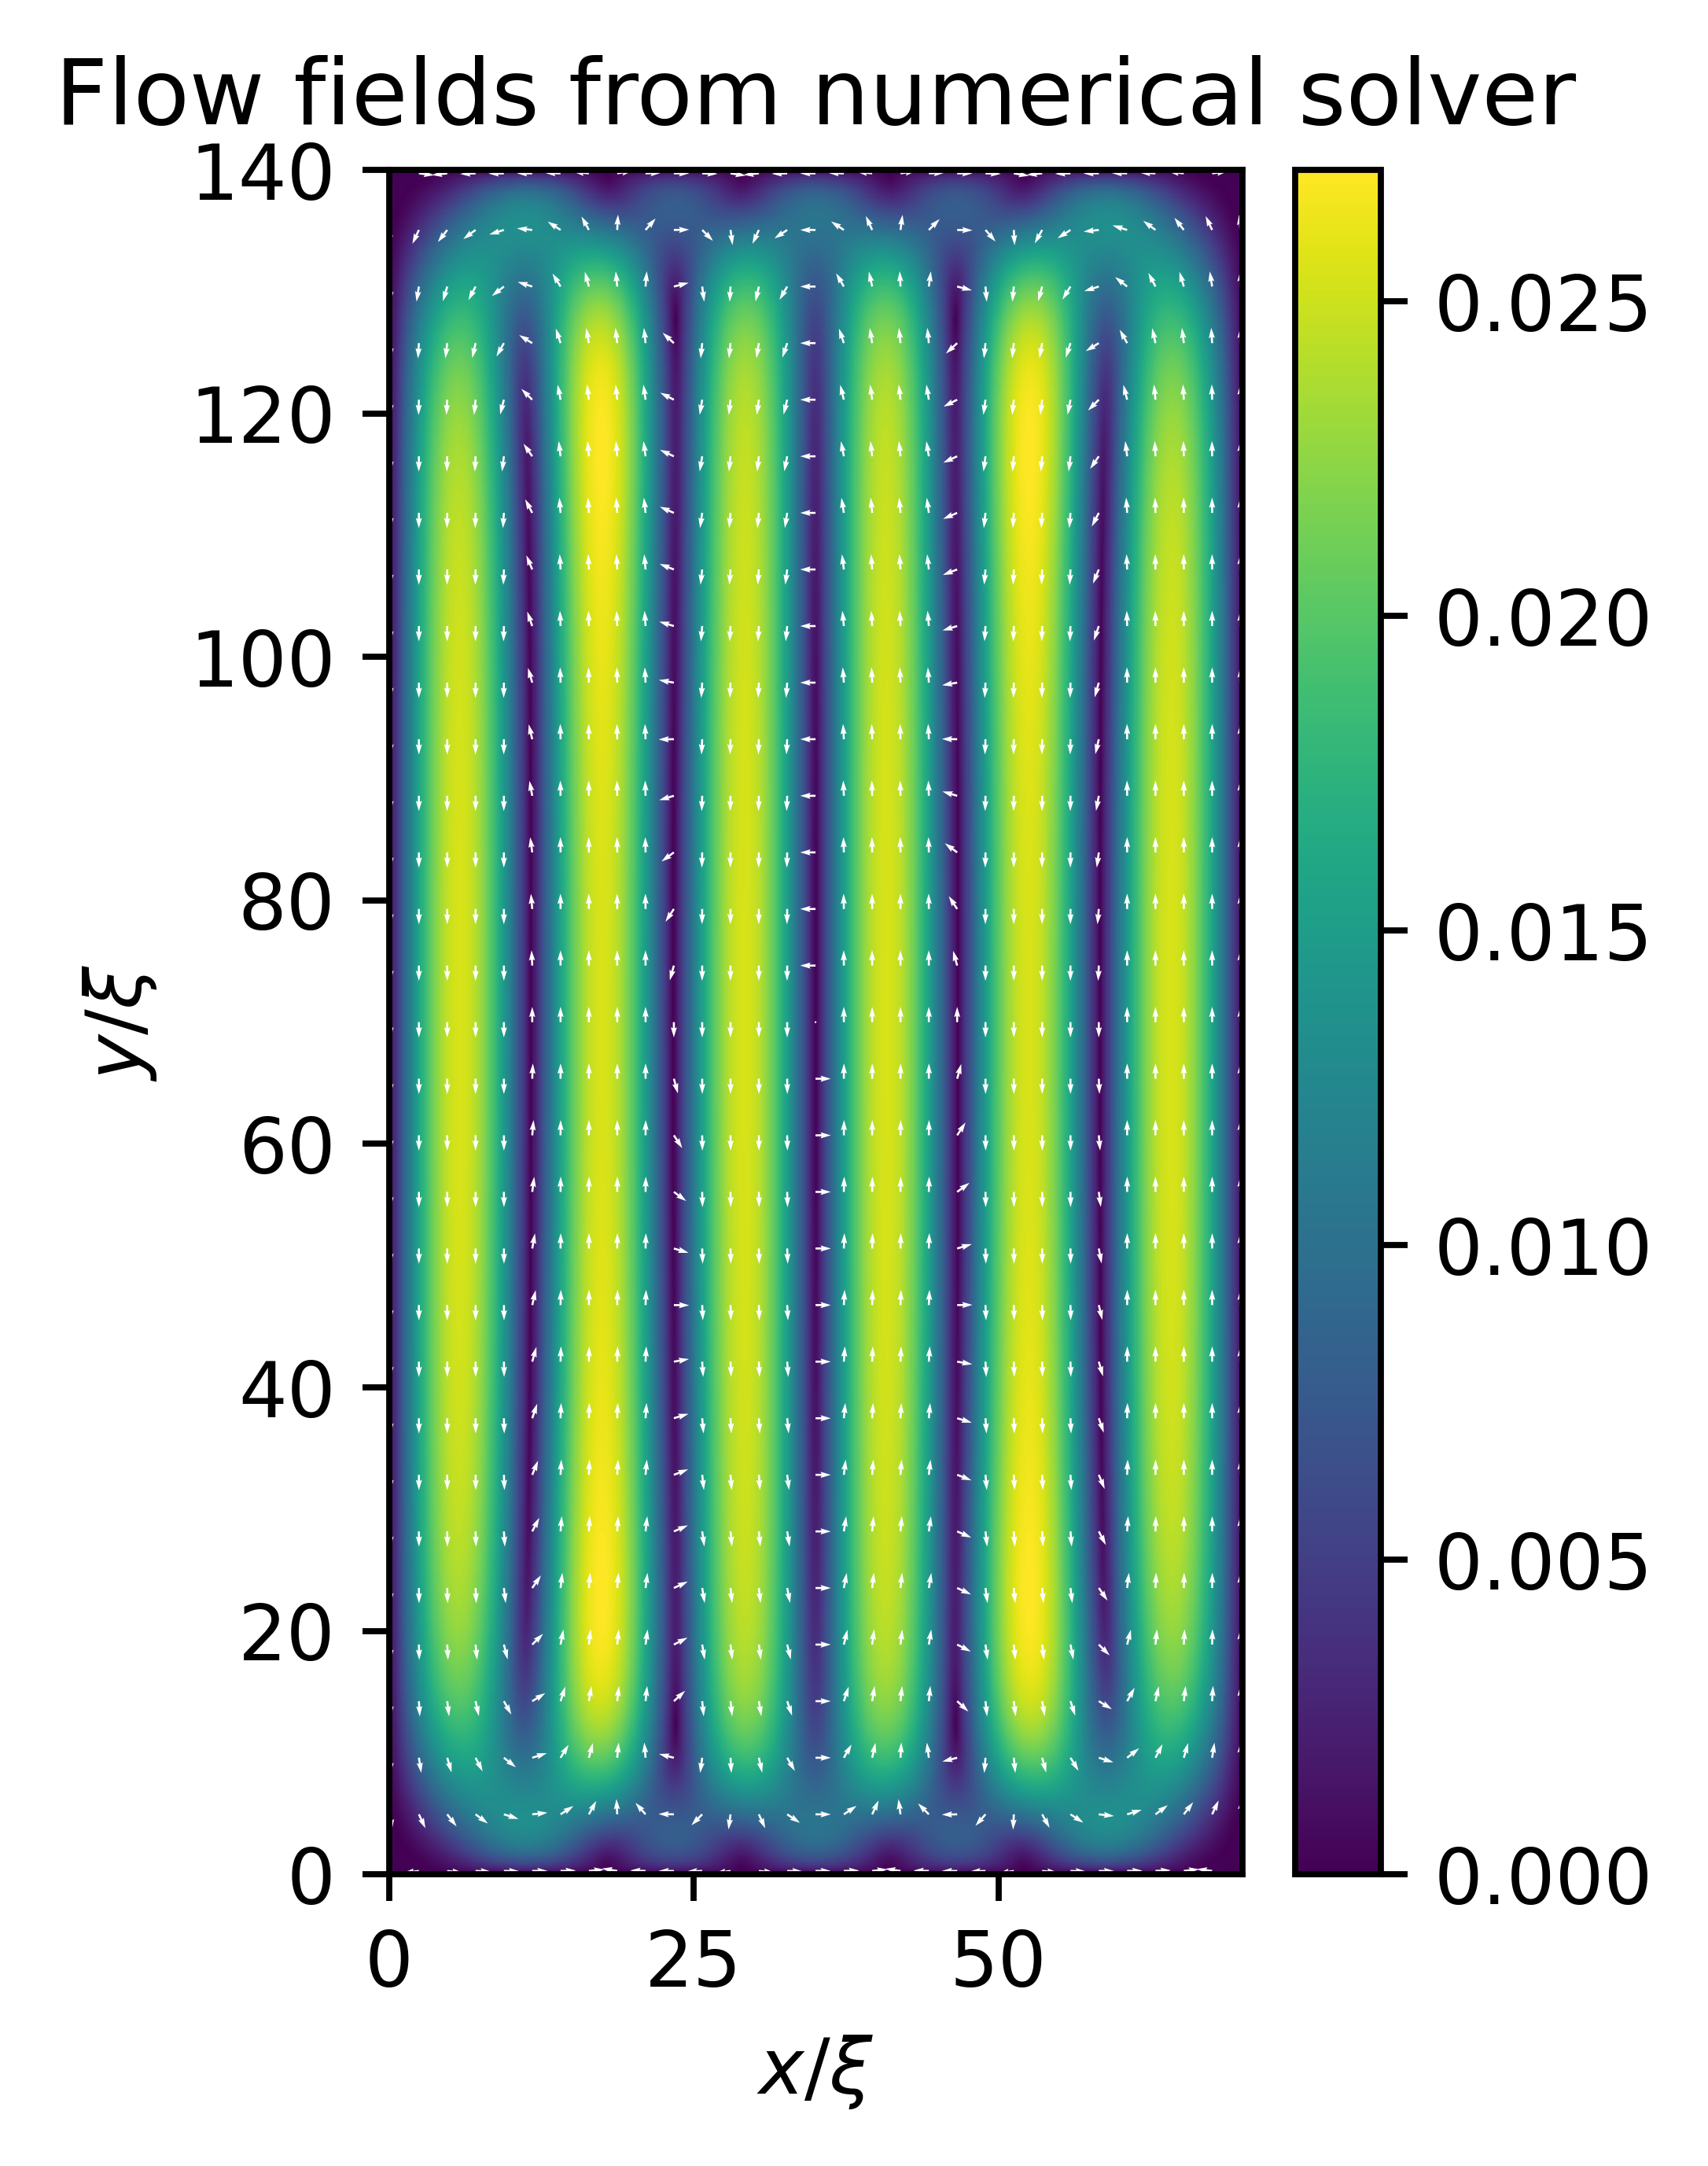

In [58]:
vx, vy = fd.curl(psi, dx, dy)
v = np.sqrt(vx**2 + vy**2)

mask = np.where(v != 0)
vx_norm = np.zeros(vx.shape)
vy_norm = np.zeros(vy.shape)
vx_norm[mask] = vx[mask]/v[mask]
vy_norm[mask] = vy[mask]/v[mask]

sparse_idx = lch.sparseIdx(vx.shape, (30, 30))

fig, ax = plt.subplots(figsize=(2.5, 4.1))
c = ax.pcolor(X, Y, v)
fig.colorbar(c, ax=ax)
q = ax.quiver(X[sparse_idx], Y[sparse_idx],
              vx_norm[sparse_idx], vy_norm[sparse_idx], pivot='tail', color='w')
ax.set_title('Flow fields from numerical solver')
ax.set_xlabel(r'$x/\xi$')
ax.set_ylabel(r'$y/\xi$')
ax.axis('equal')

filename_stress_tensor = os.path.join(save_folder, r'flow-field-numerical-6-periods.png')
fig.savefig(filename_stress_tensor)

In [55]:
alpha = 1/(lch.b - (1/4)*lch.a**2)
def analyticVelocity(x):
    return -3*alpha*lch.a*S/(4*k_x) * (lch.A + S*lch.B + 3*S**2/2 * lch.C + k_x**2) * epsilon * np.sin(k_x*x)

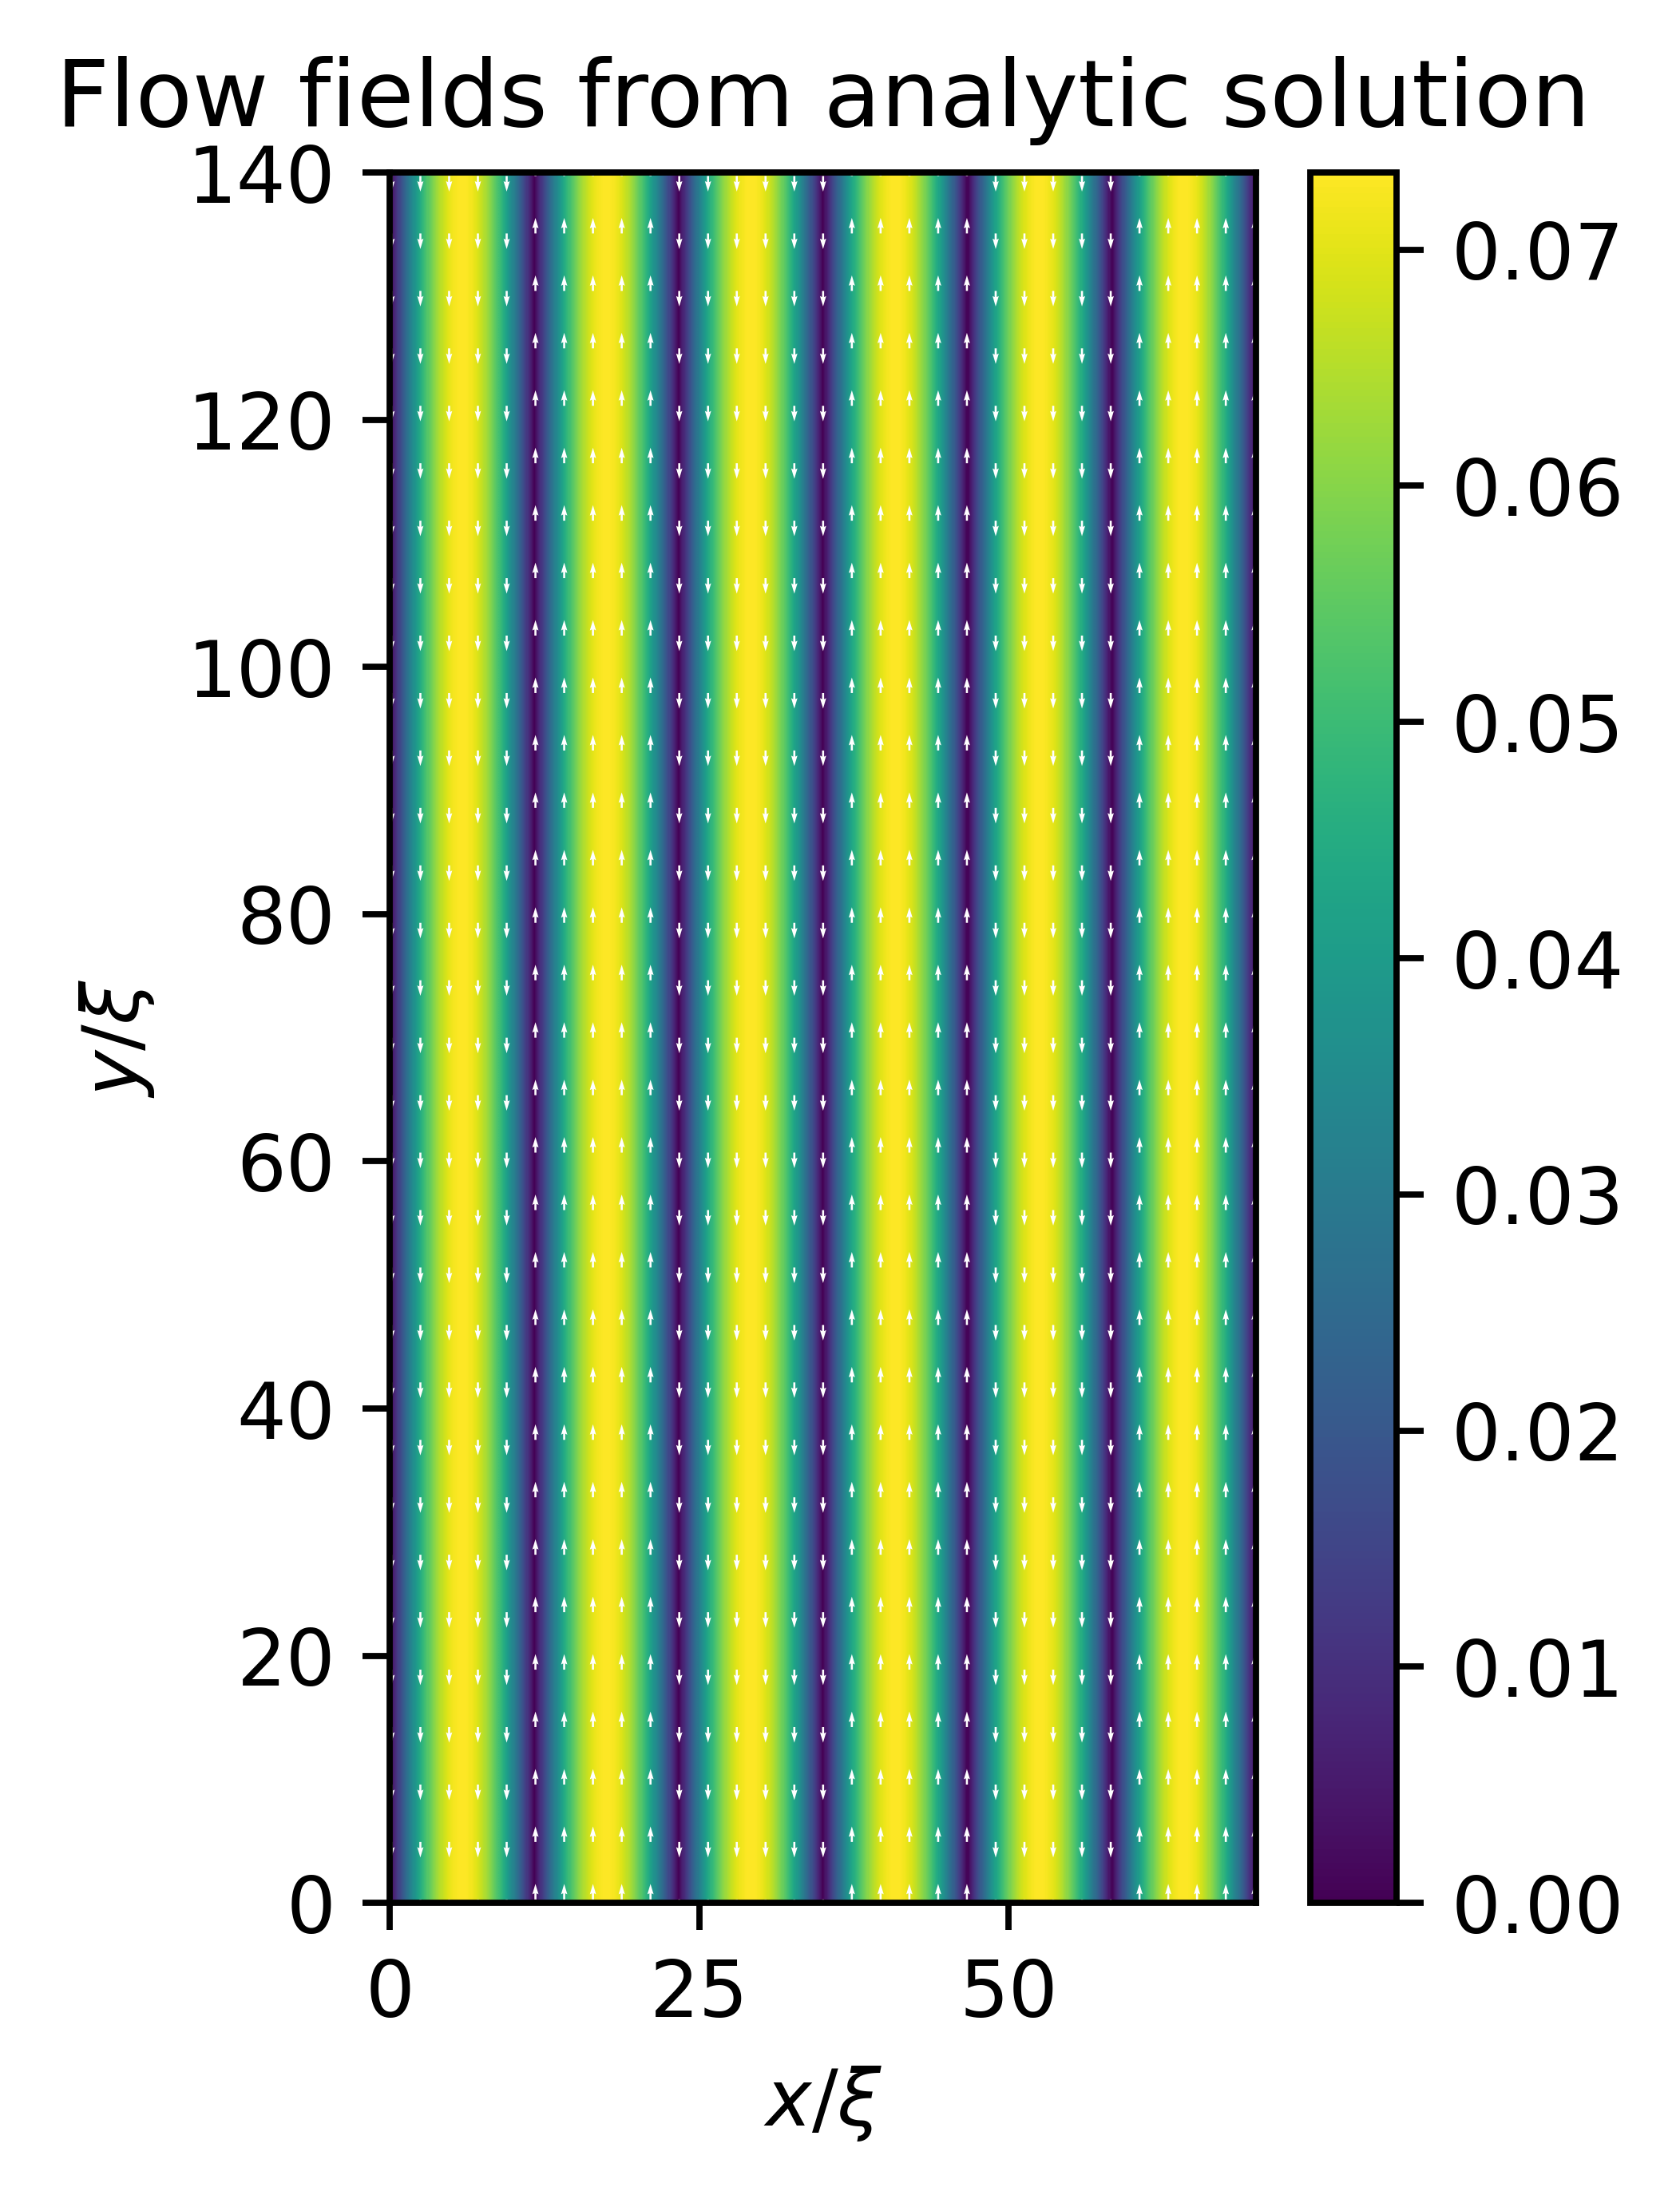

In [59]:
vx = 0*X
vy = analyticVelocity(X)
v = np.sqrt(vx**2 + vy**2)

mask = np.where(v != 0)
vx_norm = np.zeros(vx.shape)
vy_norm = np.zeros(vy.shape)
vx_norm[mask] = vx[mask]/v[mask]
vy_norm[mask] = vy[mask]/v[mask]

sparse_idx = lch.sparseIdx(vx.shape, (30, 30))

fig, ax = plt.subplots(figsize=(2.5, 4.1))
c = ax.pcolor(X, Y, v)
fig.colorbar(c, ax=ax)
q = ax.quiver(X[sparse_idx], Y[sparse_idx],
              vx_norm[sparse_idx], vy_norm[sparse_idx], pivot='tail', color='w')
ax.set_title('Flow fields from analytic solution')
ax.set_xlabel(r'$x/\xi$')
ax.set_ylabel(r'$y/\xi$')
ax.axis('equal')

filename_stress_tensor = os.path.join(save_folder, r'flow-field-analytic-6-periods.png')
fig.savefig(filename_stress_tensor)

# Now for 10 periods

In [60]:
epsilon = 0.1
S = 0.5
n_hat = np.zeros((3,) + np.shape(X))

k_x = 10*np.pi/l

n_hat[0] = epsilon*np.cos(k_x*X)
n_hat[1] = 1

Q = np.zeros((3, 3) + np.shape(X))
I = np.eye(n, n)

for i in range(3):
    for j in range(3):
        Q[i, j] = (S/2)*(3*n_hat[i]*n_hat[j] - I[i, j])

In [61]:
eta, mu, nu = lch.auxVars(Q)

In [62]:
psi = np.zeros(eta.shape)
source_term = (1 / (lch.b - (1/4)*lch.a**2)) * ( 2*lch.f1(eta, mu, nu, dx, dy) + (1/2)*lch.a*lch.f2(eta, mu, nu, dx, dy) )
psi[1:-1, 1:-1], info, calls = bh_solver.solve(source_term[1:-1, 1:-1])

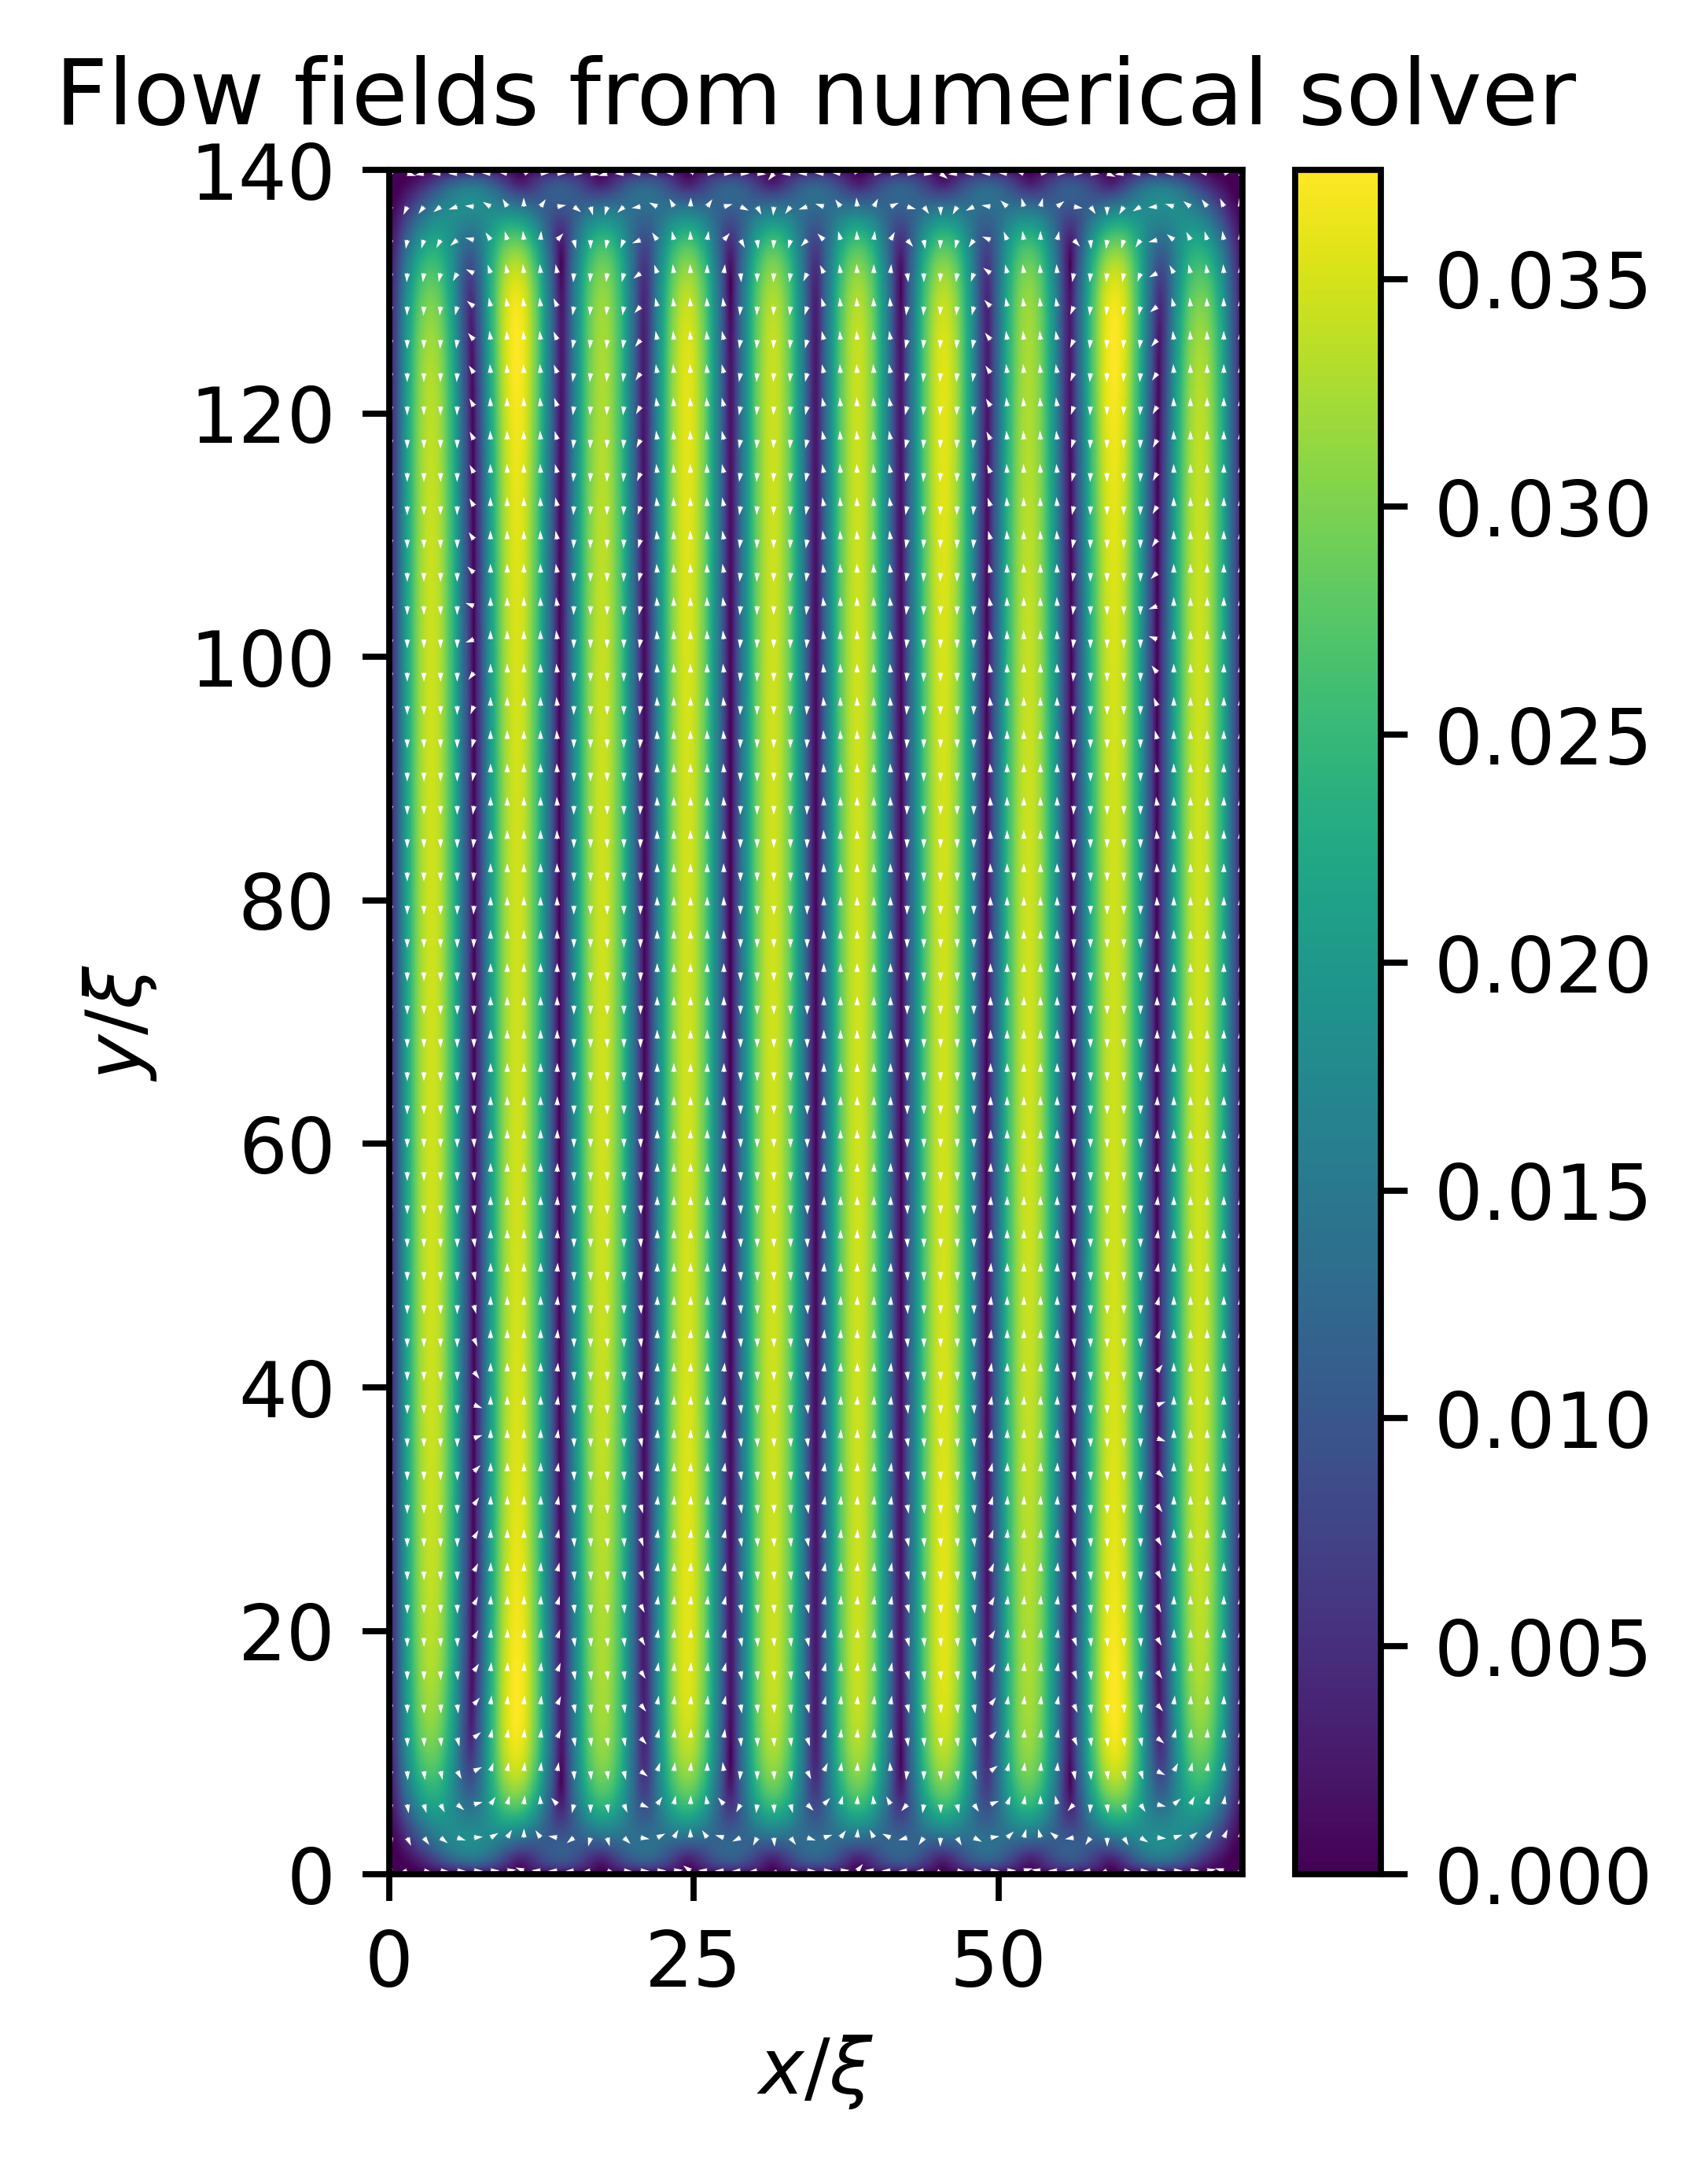

In [69]:
vx, vy = fd.curl(psi, dx, dy)
v = np.sqrt(vx**2 + vy**2)

mask = np.where(v != 0)
vx_norm = np.zeros(vx.shape)
vy_norm = np.zeros(vy.shape)
vx_norm[mask] = vx[mask]/v[mask]
vy_norm[mask] = vy[mask]/v[mask]

sparse_idx = lch.sparseIdx(vx.shape, (50, 50))

fig, ax = plt.subplots(figsize=(2.5, 4.1))
c = ax.pcolor(X, Y, v)
fig.colorbar(c, ax=ax)
q = ax.quiver(X[sparse_idx], Y[sparse_idx],
              vx_norm[sparse_idx], vy_norm[sparse_idx], pivot='tail', color='w')
ax.set_title('Flow fields from numerical solver')
ax.set_xlabel(r'$x/\xi$')
ax.set_ylabel(r'$y/\xi$')
ax.axis('equal')

filename_stress_tensor = os.path.join(save_folder, r'flow-field-numerical-10-periods.png')
fig.savefig(filename_stress_tensor)

In [65]:
alpha = 1/(lch.b - (1/4)*lch.a**2)
def analyticVelocity(x):
    return -3*alpha*lch.a*S/(4*k_x) * (lch.A + S*lch.B + 3*S**2/2 * lch.C + k_x**2) * epsilon * np.sin(k_x*x)

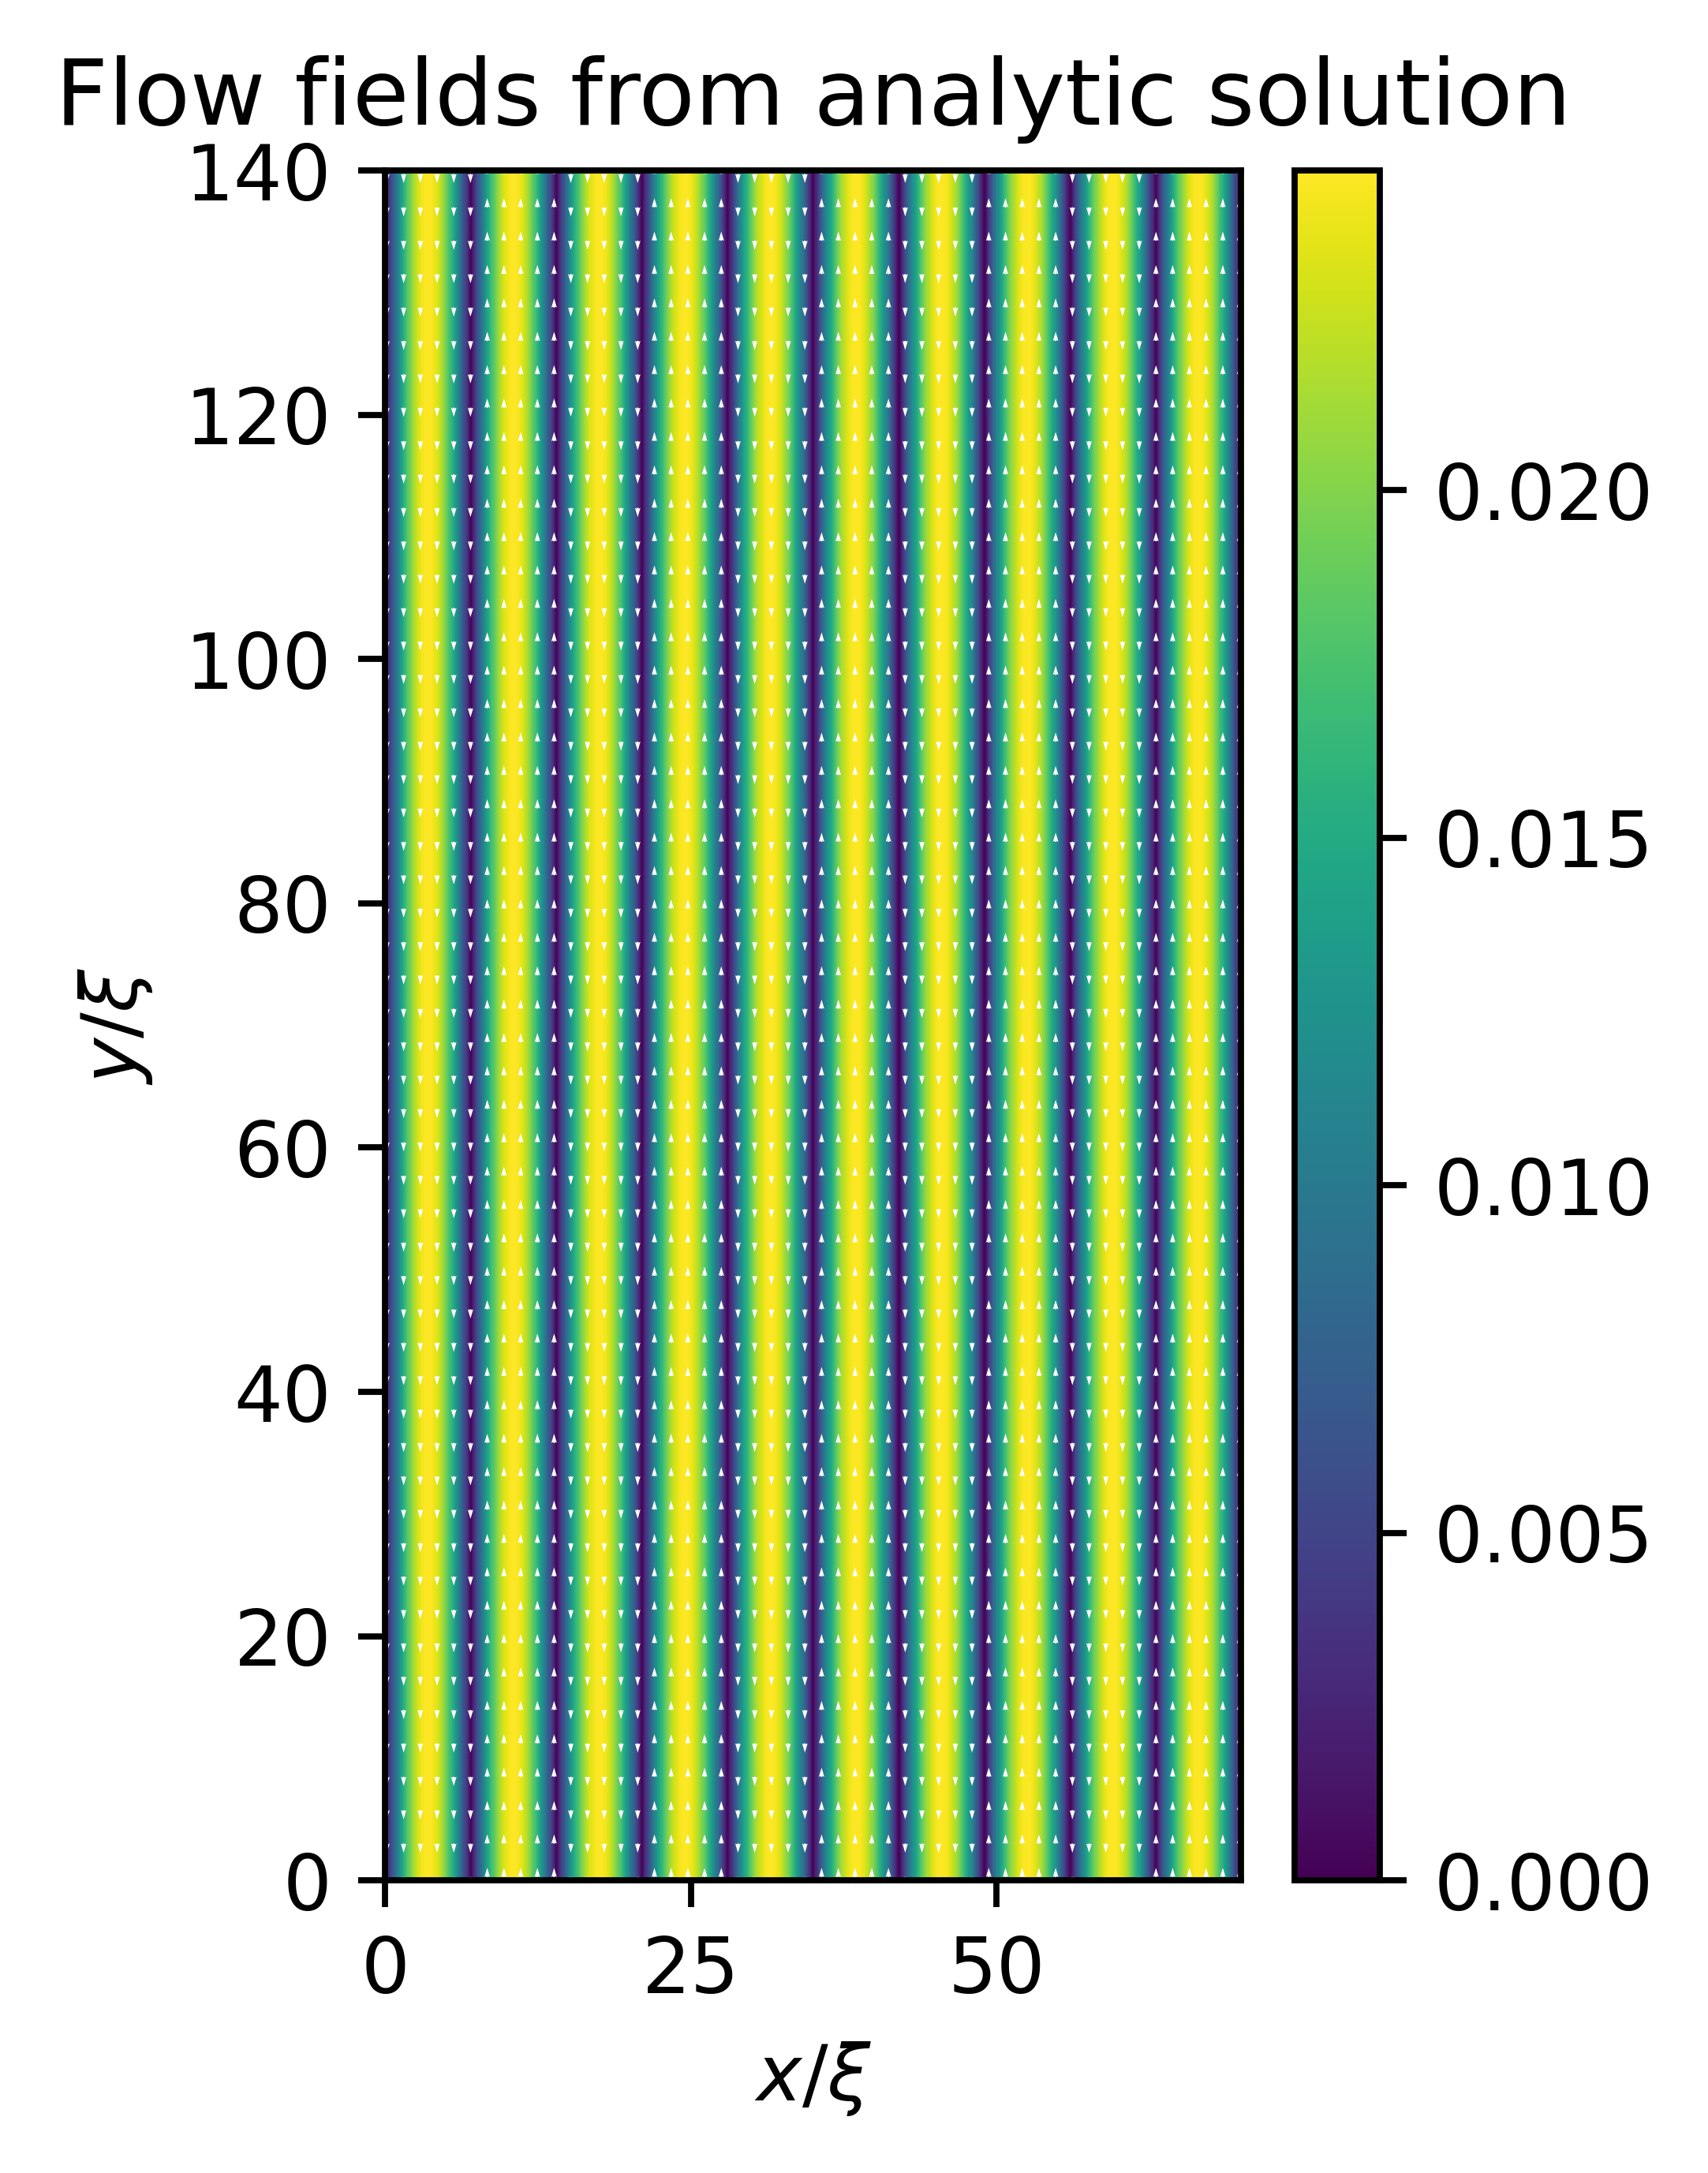

In [70]:
vx = 0*X
vy = analyticVelocity(X)
v = np.sqrt(vx**2 + vy**2)

mask = np.where(v != 0)
vx_norm = np.zeros(vx.shape)
vy_norm = np.zeros(vy.shape)
vx_norm[mask] = vx[mask]/v[mask]
vy_norm[mask] = vy[mask]/v[mask]

sparse_idx = lch.sparseIdx(vx.shape, (50, 50))

fig, ax = plt.subplots(figsize=(2.5, 4.1))
c = ax.pcolor(X, Y, v)
fig.colorbar(c, ax=ax)
q = ax.quiver(X[sparse_idx], Y[sparse_idx],
              vx_norm[sparse_idx], vy_norm[sparse_idx], pivot='tail', color='w')
ax.set_title('Flow fields from analytic solution')
ax.set_xlabel(r'$x/\xi$')
ax.set_ylabel(r'$y/\xi$')
ax.axis('equal')

filename_stress_tensor = os.path.join(save_folder, r'flow-field-analytic-10-periods.png')
fig.savefig(filename_stress_tensor)

# More

In [287]:
epsilon = 0.1
S = 0.5
n_hat = np.zeros((3,) + np.shape(X))

k_x = 50*np.pi/(2*l)

n_hat[0] = epsilon*np.cos(k_x*X)
n_hat[1] = 1

Q = np.zeros((3, 3) + np.shape(X))
I = np.eye(n, n)

for i in range(3):
    for j in range(3):
        Q[i, j] = (S/2)*(3*n_hat[i]*n_hat[j] - I[i, j])

In [288]:
eta, mu, nu = lch.auxVars(Q)

In [289]:
psi = np.zeros(eta.shape)
source_term = (1 / (lch.b - (1/4)*lch.a**2)) * ( 2*lch.f1(eta, mu, nu, dx) + (1/2)*lch.a*lch.f2(eta, mu, nu, dx) )
psi[1:-1, 1:-1], info, calls = bh_solver.solve(source_term[1:-1, 1:-1])

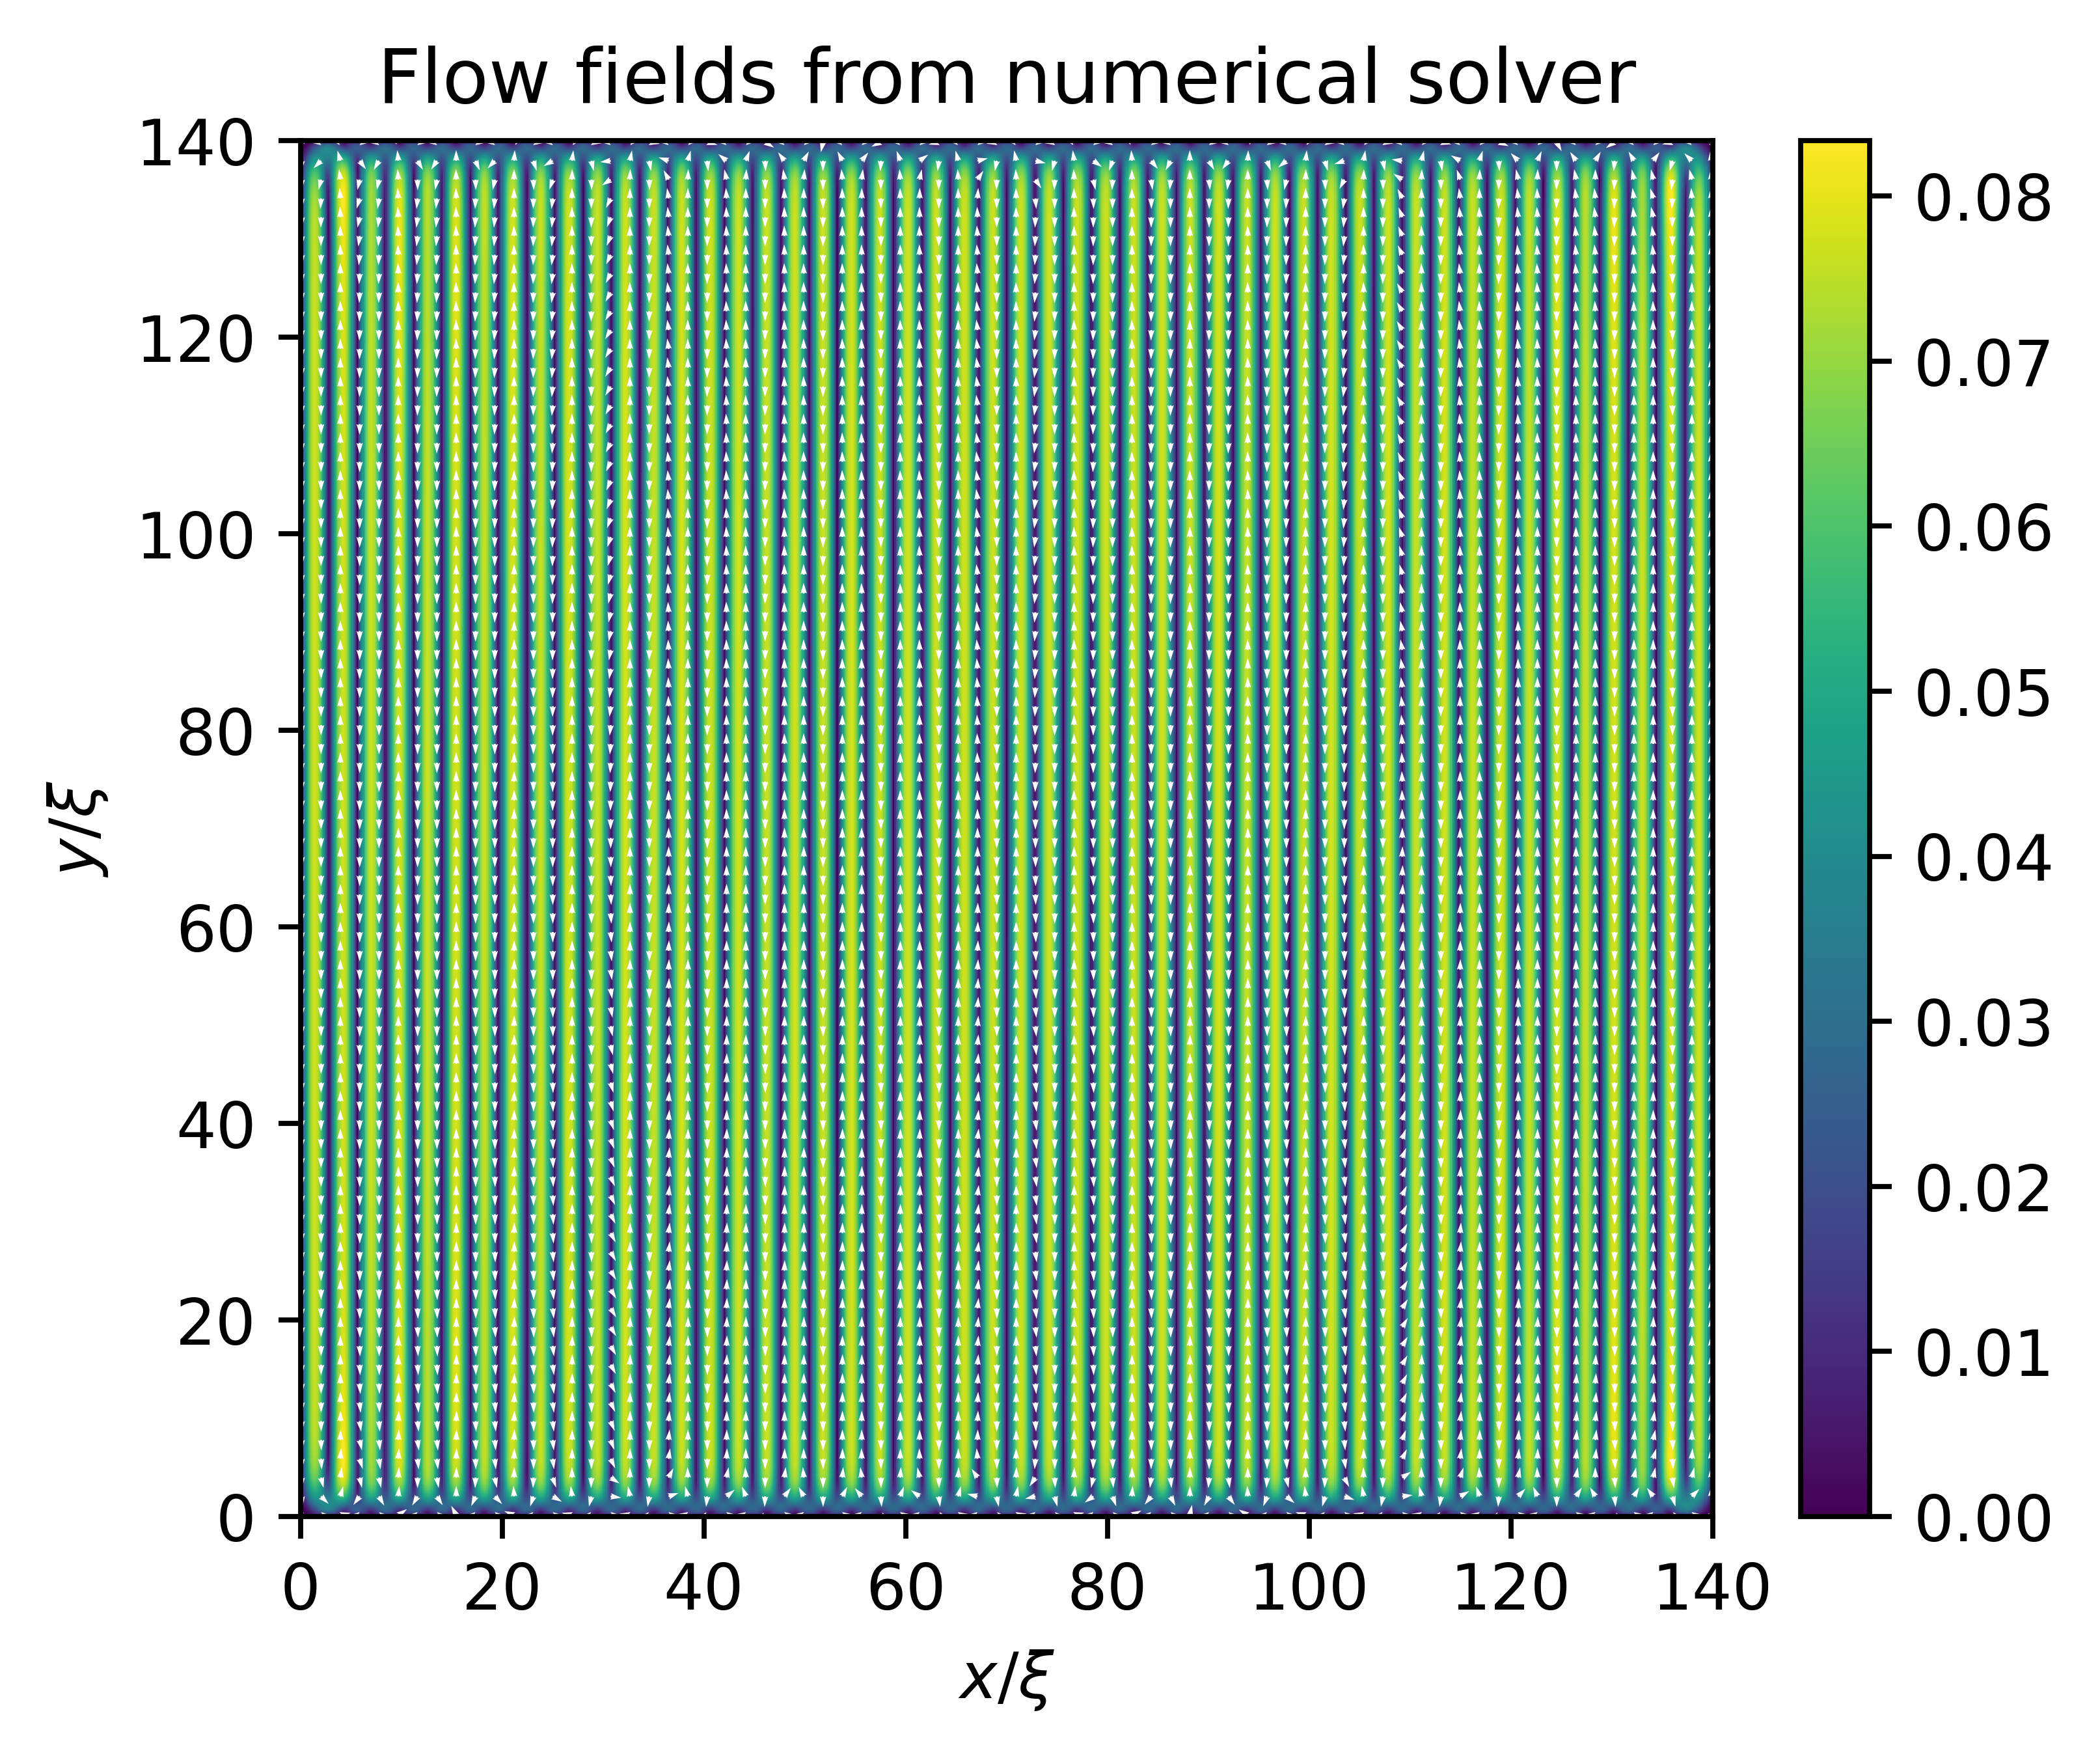

In [290]:
vx, vy = fd.curl(psi, dx)
v = np.sqrt(vx**2 + vy**2)

mask = np.where(v != 0)
vx_norm = np.zeros(vx.shape)
vy_norm = np.zeros(vy.shape)
vx_norm[mask] = vx[mask]/v[mask]
vy_norm[mask] = vy[mask]/v[mask]

sparse_idx = lch.sparseIdx(vx.shape, (70, 70))

fig, ax = plt.subplots(figsize=(5, 4))
c = ax.pcolor(X, Y, v)
fig.colorbar(c, ax=ax)
q = ax.quiver(X[sparse_idx], Y[sparse_idx],
              vx_norm[sparse_idx], vy_norm[sparse_idx], pivot='tail', color='w')
ax.set_title('Flow fields from numerical solver')
ax.set_xlabel(r'$x/\xi$')
ax.set_ylabel(r'$y/\xi$')

filename_stress_tensor = os.path.join(save_folder, r'flow-field-numerical-50-periods.png')
fig.savefig(filename_stress_tensor)